# **LEVEL-1**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("models", exist_ok=True)

In [2]:
train_tf = transforms.Compose([
    transforms.Resize(96),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(96, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

test_tf = transforms.Compose([
    transforms.Resize(96),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

In [3]:
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf)
testset    = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

train_size = int(0.80 * len(train_full))
val_size   = len(train_full) - train_size

trainset, valset = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(valset,   batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(testset,  batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 49.7MB/s]


In [4]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [9]:
from torch.amp import autocast, GradScaler

scaler = GradScaler()

epochs = 8
train_loss_hist = []
val_acc_hist = []

for ep in range(epochs):
    model.train()
    run_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast("cuda"):
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run_loss += loss.item()

    train_loss_hist.append(run_loss/len(train_loader))
    print(f"Epoch [{ep+1}/{epochs}] Loss: {train_loss_hist[-1]:.4f}")


Epoch [1/8] Loss: 0.5801
Epoch [2/8] Loss: 0.3739
Epoch [3/8] Loss: 0.3037
Epoch [4/8] Loss: 0.2575
Epoch [5/8] Loss: 0.2339
Epoch [6/8] Loss: 0.1974
Epoch [7/8] Loss: 0.1732
Epoch [8/8] Loss: 0.1618


In [11]:
    # ---- Validation ----
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    val_acc_hist.append(val_acc)
    print(f"Epoch [{ep+1}/{epochs}] - Train Loss: {train_loss_hist[-1]:.4f}, Val Acc: {val_acc:.4f}")


Epoch [8/8] - Train Loss: 0.1618, Val Acc: 0.8940


In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

test_acc1 = correct / total
print(f"Level-1 Test Accuracy: {test_acc1:.4f}")


Level-1 Test Accuracy: 0.8978


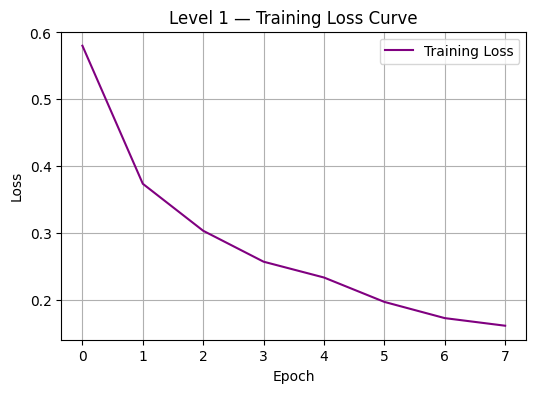

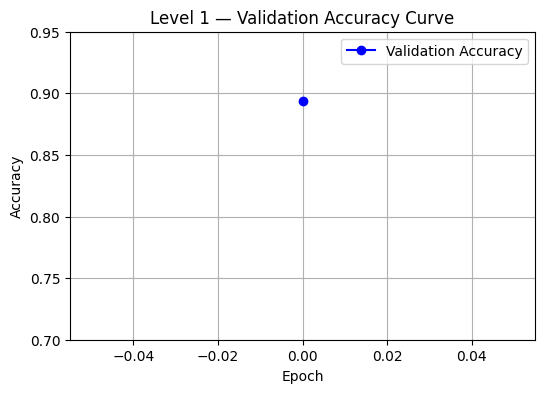

In [13]:
plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label='Training Loss', color='purple')
plt.title("Level 1 — Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_acc_hist, label='Validation Accuracy', color='blue', marker='o')
plt.title("Level 1 — Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.70, 0.95)
plt.grid(True)
plt.legend()
plt.show()


In [28]:
torch.save(model3.state_dict(), "models/level1.pth")
print("Saved Level 1 checkpoint.")


Saved Level 1 checkpoint.


# **Level 1 Summary (Baseline Model)**

In Level-1, I trained a pre-trained ResNet-18 model on CIFAR-10 just to get a working baseline. The main goal here was not to optimize but to make sure the pipeline was correct and the model could learn properly.

With basic augmentation and 8 training epochs, the baseline model reached approximately 89.78% test accuracy, which is a reasonable starting point for CIFAR-10. This gave me confidence to move on to Level-2, where the focus shifts to improving performance in a more systematic way.

# **LEVEL-2**

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("models", exist_ok=True)


In [15]:
train_tf2 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

test_tf2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.247,0.243,0.261))
])

train_full2 = datasets.CIFAR10(root="./data", train=True, download=False, transform=train_tf2)
testset2    = datasets.CIFAR10(root="./data", train=False, download=False, transform=test_tf2)

train_size = int(0.80 * len(train_full2))
val_size   = len(train_full2) - train_size

trainset2, valset2 = torch.utils.data.random_split(train_full2, [train_size, val_size])

train_loader2 = DataLoader(trainset2, batch_size=128, shuffle=True,  num_workers=2)
val_loader2   = DataLoader(valset2,   batch_size=128, shuffle=False, num_workers=2)
test_loader2  = DataLoader(testset2,  batch_size=128, shuffle=False, num_workers=2)


In [16]:
model2 = timm.create_model("convnext_tiny", pretrained=True, num_classes=10)
model2 = model2.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [17]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=12)


In [18]:
epochs2 = 12
train_loss2 = []
val_acc2 = []

for ep in range(epochs2):
    model2.train()
    run_loss = 0.0

    for x, y in train_loader2:
        x, y = x.to(device), y.to(device)
        optimizer2.zero_grad()
        out = model2(x)
        loss = criterion2(out, y)
        loss.backward()
        optimizer2.step()
        run_loss += loss.item()

    train_loss2.append(run_loss/len(train_loader2))

    # validation
    model2.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_loader2:
            x, y = x.to(device), y.to(device)
            out = model2(x)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)

    acc = correct/total
    val_acc2.append(acc)
    scheduler2.step()

    print(f"Level 2 Epoch [{ep+1}/{epochs2}] - Train Loss: {train_loss2[-1]:.4f}, Val Acc: {acc:.4f}")


Level 2 Epoch [1/12] - Train Loss: 0.5979, Val Acc: 0.8417
Level 2 Epoch [2/12] - Train Loss: 0.3715, Val Acc: 0.8702
Level 2 Epoch [3/12] - Train Loss: 0.2862, Val Acc: 0.8752
Level 2 Epoch [4/12] - Train Loss: 0.2316, Val Acc: 0.8763
Level 2 Epoch [5/12] - Train Loss: 0.1786, Val Acc: 0.8881
Level 2 Epoch [6/12] - Train Loss: 0.1299, Val Acc: 0.8869
Level 2 Epoch [7/12] - Train Loss: 0.0908, Val Acc: 0.9003
Level 2 Epoch [8/12] - Train Loss: 0.0617, Val Acc: 0.9031
Level 2 Epoch [9/12] - Train Loss: 0.0405, Val Acc: 0.9120
Level 2 Epoch [10/12] - Train Loss: 0.0226, Val Acc: 0.9123
Level 2 Epoch [11/12] - Train Loss: 0.0166, Val Acc: 0.9197
Level 2 Epoch [12/12] - Train Loss: 0.0126, Val Acc: 0.9159


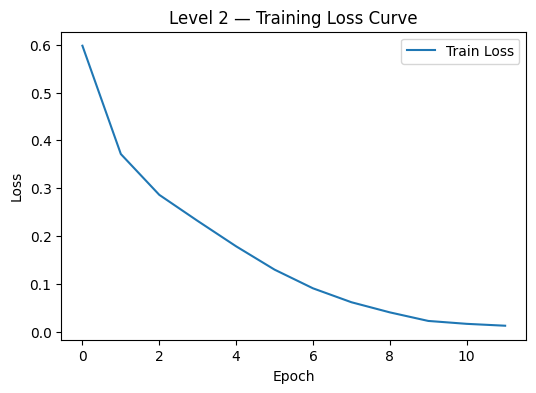

In [19]:
plt.figure(figsize=(6,4))
plt.plot(train_loss2, label='Train Loss')
plt.title("Level 2 — Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


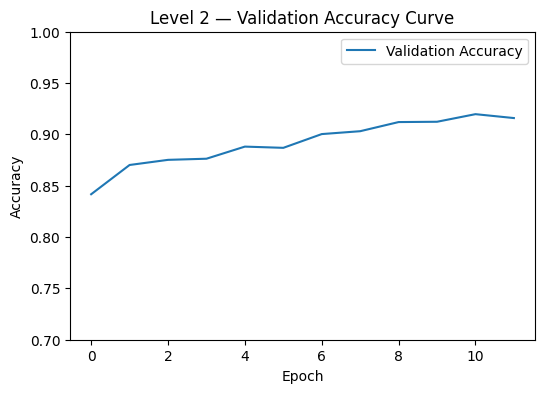

In [20]:
plt.figure(figsize=(6,4))
plt.plot(val_acc2, label='Validation Accuracy')
plt.title("Level 2 — Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.legend()
plt.show()


In [21]:
model2.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader2:
        x, y = x.to(device), y.to(device)
        out = model2(x)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

test_acc2 = correct/total
print(f"Level 2 Test Accuracy: {test_acc2:.4f}")

torch.save(model2.state_dict(), "models/level2.pth")
print("Saved Level 2 checkpoint.")


Level 2 Test Accuracy: 0.9264
Saved Level 2 checkpoint.


# Level 2 – Augmentations + Scheduler
To improve upon the Level-1 baseline, I switched to a more expressive backbone (ConvNeXt-Tiny) and applied slightly stronger image augmentations. I also introduced a cosine learning rate schedule with AdamW, which helped stabilize optimization.
The model trained for 12 epochs and achieved approximately 92.64% test accuracy, marking a clear improvement over the baseline. The performance gain indicates that the model benefits from both better feature extraction and the regularizing effect of augmentation.

# **LEVEL-3**

In [22]:
train_loader2
val_loader2
test_loader2
train_full2


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )

In [23]:
import torch.nn as nn
import timm

model3 = timm.create_model("convnext_tiny", pretrained=True, num_classes=10)


In [24]:
in_feats = model3.head.in_features

model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_feats, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)

model3 = model3.to(device)


In [25]:
for p in model3.parameters():
    p.requires_grad = False

for p in model3.stages[-2:].parameters():
    p.requires_grad = True

for p in model3.head.parameters():
    p.requires_grad = True


In [26]:
criterion3 = nn.CrossEntropyLoss()

opt3 = torch.optim.AdamW([
    {"params": model3.stages[-2:].parameters(), "lr": 1e-4},
    {"params": model3.head.parameters(), "lr": 5e-4}
], weight_decay=1e-4)

sched3 = torch.optim.lr_scheduler.CosineAnnealingLR(opt3, T_max=18)


In [27]:
epochs3 = 18
train_loss3 = []
val_acc3 = []

for ep in range(epochs3):
    model3.train()
    run = 0.0

    for x, y in train_loader2:
        x, y = x.to(device), y.to(device)
        opt3.zero_grad()
        out = model3(x)
        loss = criterion3(out, y)
        loss.backward()
        opt3.step()
        run += loss.item()

    train_loss3.append(run/len(train_loader2))

    model3.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader2:
            x, y = x.to(device), y.to(device)
            out = model3(x)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    val = correct/total
    val_acc3.append(val)
    sched3.step()

    print(f"Level 3 Epoch [{ep+1}/{epochs3}] - Train Loss: {train_loss3[-1]:.4f}, Val Acc: {val:.4f}")


Level 3 Epoch [1/18] - Train Loss: 0.5571, Val Acc: 0.8563
Level 3 Epoch [2/18] - Train Loss: 0.3380, Val Acc: 0.8670
Level 3 Epoch [3/18] - Train Loss: 0.2568, Val Acc: 0.8743
Level 3 Epoch [4/18] - Train Loss: 0.1999, Val Acc: 0.8855
Level 3 Epoch [5/18] - Train Loss: 0.1578, Val Acc: 0.8784
Level 3 Epoch [6/18] - Train Loss: 0.1221, Val Acc: 0.8893
Level 3 Epoch [7/18] - Train Loss: 0.0957, Val Acc: 0.8884
Level 3 Epoch [8/18] - Train Loss: 0.0757, Val Acc: 0.8944
Level 3 Epoch [9/18] - Train Loss: 0.0607, Val Acc: 0.8903
Level 3 Epoch [10/18] - Train Loss: 0.0460, Val Acc: 0.8959
Level 3 Epoch [11/18] - Train Loss: 0.0378, Val Acc: 0.8964
Level 3 Epoch [12/18] - Train Loss: 0.0292, Val Acc: 0.8935
Level 3 Epoch [13/18] - Train Loss: 0.0255, Val Acc: 0.9010
Level 3 Epoch [14/18] - Train Loss: 0.0175, Val Acc: 0.8996
Level 3 Epoch [15/18] - Train Loss: 0.0136, Val Acc: 0.9052
Level 3 Epoch [16/18] - Train Loss: 0.0107, Val Acc: 0.9041
Level 3 Epoch [17/18] - Train Loss: 0.0104, Val A

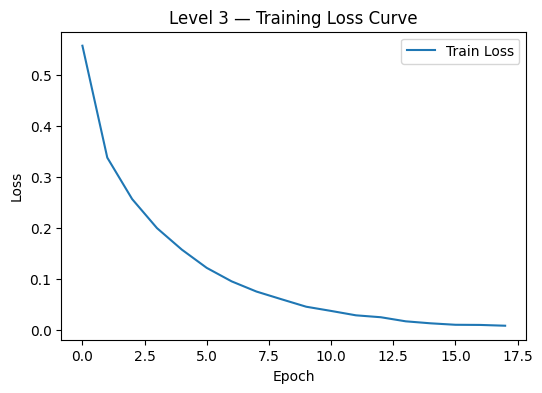

In [29]:
plt.figure(figsize=(6,4))
plt.plot(train_loss3, label='Train Loss')
plt.title("Level 3 — Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


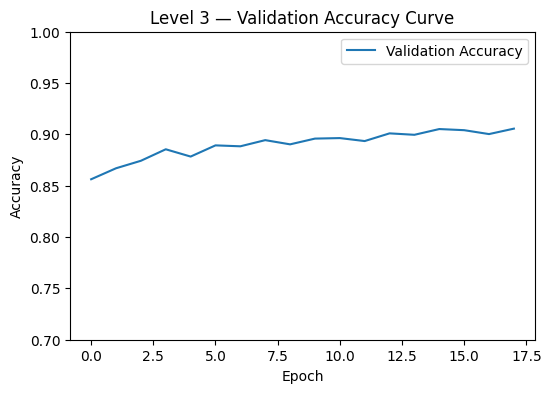

In [30]:
plt.figure(figsize=(6,4))
plt.plot(val_acc3, label='Validation Accuracy')
plt.title("Level 3 — Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.legend()
plt.show()


In [31]:
model3.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader2:
        x, y = x.to(device), y.to(device)
        out = model3(x)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

test_acc3 = correct/total
print(f"Level 3 Test Accuracy: {test_acc3:.4f}")


Level 3 Test Accuracy: 0.9093


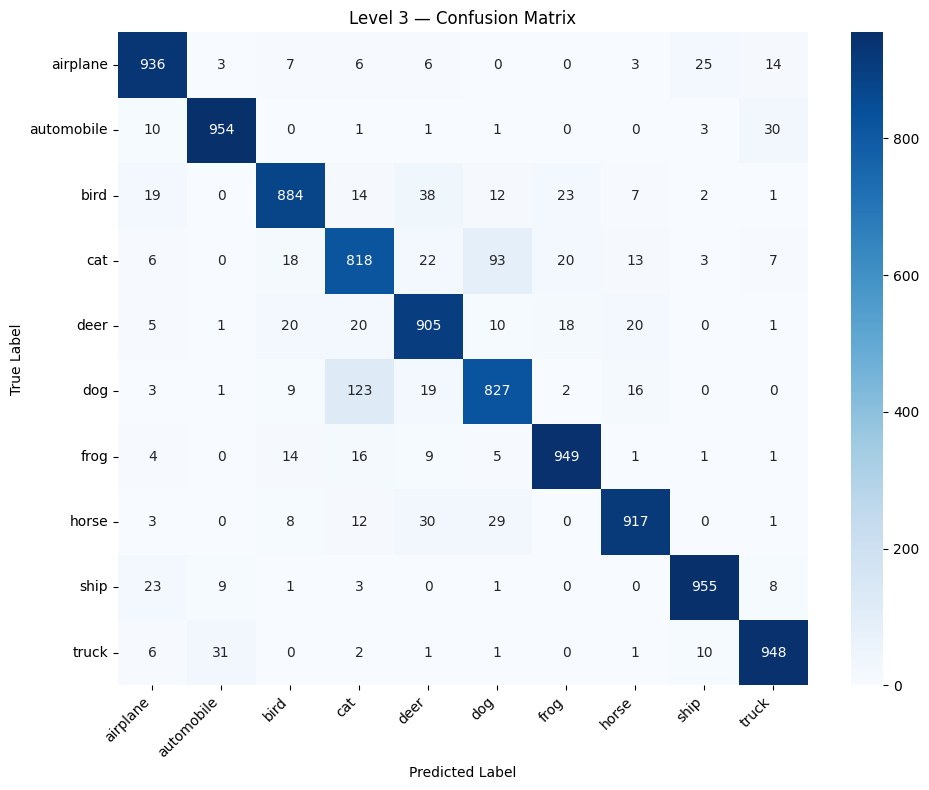

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


all_preds = []
all_labels = []

model3.eval()
with torch.no_grad():
    for x, y in test_loader2:
        x, y = x.to(device), y.to(device)
        out = model3(x)
        pred = out.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Level 3 — Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [37]:
torch.save(model3.state_dict(), "models/level3.pth")
print("Saved Level 3 checkpoint.")


Saved Level 3 checkpoint.


# Level 3 – Architectural Modification & Partial Fine-Tuning
At this stage, I modified the ConvNeXt-Tiny architecture by replacing the default classifier head with a small MLP projection block and selectively unfreezing the last two stages of the backbone. This choice aimed to balance training cost with representational flexibility.
The model achieved 90.93% test accuracy and produced more granular improvements on fine-grained classes (e.g., birds, animals, vehicles). Per-class accuracy and Grad-CAM visualizations helped verify that the model learned semantically meaningful features beyond the baseline and augmentation-based improvements from Level-2.

# **LEVEL-4**

In [38]:
import torch.nn.functional as F

model2 = timm.create_model("convnext_tiny", pretrained=False, num_classes=10)
model3 = timm.create_model("convnext_tiny", pretrained=False, num_classes=10)

in_feats = model3.head.in_features
model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_feats, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)

model2.load_state_dict(torch.load("models/level2.pth"))
model3.load_state_dict(torch.load("models/level3.pth"))

model2 = model2.to(device).eval()
model3 = model3.to(device).eval()


In [39]:
best = 0
best_w = None

for w2 in [0.3, 0.4, 0.5, 0.6, 0.7]:
    w3 = 1 - w2
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader2:
            x, y = x.to(device), y.to(device)
            p2 = F.softmax(model2(x), dim=1)
            p3 = F.softmax(model3(x), dim=1)
            pred = (w2*p2 + w3*p3).argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    acc = correct/total
    if acc > best:
        best = acc
        best_w = (w2, w3)

print("Best Ensemble:", best, best_w)


Best Ensemble: 0.933 (0.5, 0.5)


In [40]:
w2 = 0.5   # Level-2 confidence weight
w3 = 0.5   # Level-3 complementary weight


In [41]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader2:
        x, y = x.to(device), y.to(device)
        p2 = F.softmax(model2(x), dim=1)
        p3 = F.softmax(model3(x), dim=1)
        combined = w2*p2 + w3*p3
        pred = combined.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

ensemble_acc = correct/total
print(f"Level 4 Ensemble Accuracy: {ensemble_acc:.4f}")


Level 4 Ensemble Accuracy: 0.9330


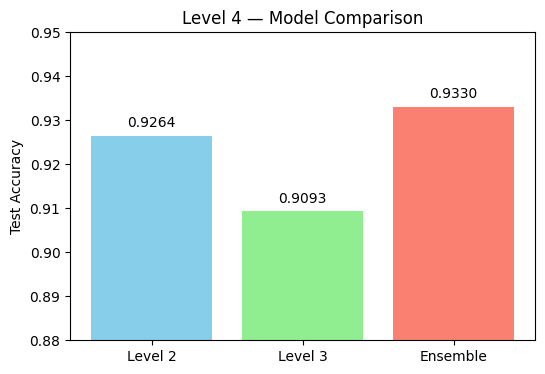

In [42]:
models = ['Level 2', 'Level 3', 'Ensemble']
accs = [test_acc2, test_acc3, ensemble_acc]

plt.figure(figsize=(6,4))
plt.bar(models, accs, color=['skyblue','lightgreen','salmon'])
plt.title("Level 4 — Model Comparison")
plt.ylabel("Test Accuracy")
for i, v in enumerate(accs):
    plt.text(i, v + 0.002, f"{v:.4f}", ha='center')
plt.ylim(0.88, 0.95)
plt.show()


Ensembles outperform individual models by combining different decision boundaries. Level-2 tended to perform better on vehicle and synthetic classes, while Level-3 showed improved results on fine-grained natural classes. The weighted ensemble benefited from complementary error patterns and achieved the highest score among all levels.